<a href="https://colab.research.google.com/github/LorenzoMauri/Advanced-Machine-Learning/blob/main/Copy_of_AML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
from shutil import copyfile
import tarfile
from skimage import transform
import keras
import skimage
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from keras import Model
from keras.layers import Conv2D,Input,MaxPooling2D,Dense,Flatten,Dropout

In [2]:
copyfile('/content/drive/MyDrive/indoorCVPR_09/dataset_new.tar', 'dataset_new.tar')
tar = tarfile.open('dataset_new.tar')
tar.extractall()
tar.close()

In [104]:
def trainModel(model,training,validation,
               epochs=12,batch_size = 128,
               loss_func = keras.optimizers.Adam()):
  
  model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=loss_func,
            metrics=['accuracy'])

  # training
  modello = model.fit(x = training, validation_data = validation, epochs = epochs,batch_size = batch_size)
  
  return modello

def plotPerformance(modello):
  fig = plt.figure(figsize = [8,5])
  plt.subplot(1, 2, 1)
  plt.title('accuracy')
  plt.plot(modello.history['accuracy'],label='training',marker='.')
  plt.plot(modello.history['val_accuracy'],label='validation',marker='.')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.title('loss')
  plt.plot(modello.history['loss'],label='training',marker='.')
  plt.plot(modello.history['val_loss'],label='validation',marker='.')
  plt.legend()
    
  plt.show()

def confMatrixHeatmap(y_true,y_pred,report = True):
  conf_matrix = confusion_matrix(y_true, y_pred)
  heatmap = sns.heatmap(conf_matrix, annot=True, fmt="d")
  if report : 
      print("\n"*3)
      print("------------- classification report -------------")
      print(classification_report(y_true=y_true,y_pred=y_pred))
      print("-------------------------------------------------")
      print("\n"*3)
  return conf_matrix, heatmap
  
def predicted_labels(modello,test):
  categories = [0,90,180,270]
  predictions = modello.predict(test)
  return [np.argmax(prob) for prob in predictions]

def buildModel(model_type,
               input_shape = (224,224,3),units_final_layer=4):
  if model_type == 'mobilenet' : 
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False, pooling='avg')
  else :  base_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
    
    
  # blocco i layer pre-allenati in modo tale che durante le epoch rimangano fissi
  for layer in base_model.layers:
      layer.trainable = False

  # parte finale del modello di base
  x = base_model.output
  x = Flatten()(x)
  x = Dense(10, activation='relu', name='fullyConnected_0')(x)
  x = Dropout(0.5)(x)
  
  x = Dense(10, activation='relu', name='fullyConnected_1')(x)
  x = Dense(units_final_layer, activation='softmax', name='predictions')(x)

  # Modello
  model = Model(inputs=base_model.input, outputs=x)
  return model

In [16]:
def DataLoader(preprocessing_function,dataAugmentation=False,
               base_path='/content/dataset_new/',validation_split=0.1):
 
  # decido se fare data augmentation o meno  
  if dataAugmentation == False : 
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function,
                                                                 validation_split = validation_split                                                              
                                                                 )
    
    test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function,
                                                                validation_split = validation_split
                                                               )
  else : 
    train_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function ,                                  
                                      zoom_range=0.6
                                      )
    
    test_datagen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_function,
                                     zoom_range=0.6                                 
                                      )
  
  # importo i dati 
  training = train_datagen.flow_from_directory(directory=base_path+ 'training',
                                                  target_size=(224, 224),
                                                  color_mode="rgb",
                                                  batch_size=128,
                                                  class_mode="categorical",
                                                  subset = 'training',
                                                  shuffle=True,
                                                  seed=1)
  
  validation = train_datagen.flow_from_directory(directory=base_path+ 'training',
                                                  target_size=(224, 224),
                                                  color_mode="rgb",
                                                  batch_size=128,
                                                  class_mode="categorical",
                                                  subset = 'validation',
                                                  shuffle=True,
                                                  seed=1)

   
  test = test_datagen.flow_from_directory(directory=base_path+'test',
                                             target_size=(224, 224),
                                             color_mode="rgb",
                                             batch_size=128,
                                             class_mode="categorical",
                                             shuffle=True,                                            
                                             seed = 1)
  return training,validation,test

# Dataset indoorCVPR_09 




---



## Costruzione modello : fine tuning 

In [5]:
from tensorflow.keras.applications import mobilenet_v2
model_built = buildModel(model_type='mobilenet',units_final_layer=4)


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model_built.summary()

## Splitting training,validation,test

>ripartizione : 60 | 22 | 18  %

In [32]:
training,validation,test = DataLoader(preprocessing_function = mobilenet_v2.preprocess_input,validation_split=0.275)

Found 3107 images belonging to 4 classes.
Found 1175 images belonging to 4 classes.
Found 920 images belonging to 4 classes.


## Training e Validation : performances

In [36]:
model_trained_mobnet= trainModel(model_built,training,validation)

Epoch 1/12
25/25 [==============================] - 19s 420ms/step - loss: 1.3710 - accuracy: 0.3080 - val_loss: 1.2301 - val_accuracy: 0.4443
Epoch 2/12
25/25 [==============================] - 9s 373ms/step - loss: 1.2602 - accuracy: 0.3623 - val_loss: 1.1289 - val_accuracy: 0.4749
Epoch 3/12
25/25 [==============================] - 10s 380ms/step - loss: 1.1939 - accuracy: 0.3966 - val_loss: 1.0663 - val_accuracy: 0.5064
Epoch 4/12
25/25 [==============================] - 10s 380ms/step - loss: 1.1287 - accuracy: 0.4377 - val_loss: 1.0342 - val_accuracy: 0.5506
Epoch 5/12
25/25 [==============================] - 9s 378ms/step - loss: 1.0923 - accuracy: 0.4333 - val_loss: 0.9790 - val_accuracy: 0.5745
Epoch 6/12
25/25 [==============================] - 9s 378ms/step - loss: 1.0716 - accuracy: 0.4687 - val_loss: 0.9234 - val_accuracy: 0.5702
Epoch 7/12
25/25 [==============================] - 9s 376ms/step - loss: 1.0386 - accuracy: 0.4535 - val_loss: 0.8799 - val_accuracy: 0.5770
Epo

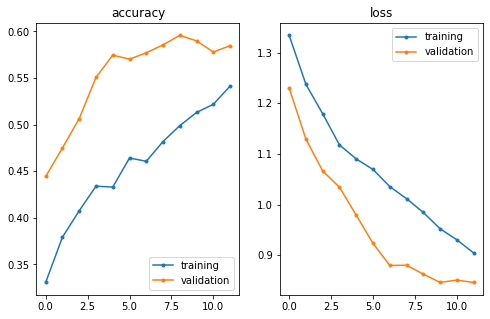

In [43]:
plotPerformance(model_trained_mobnet)

In [66]:
predictions = model_built.predict(test)
predictions

array([[2.3421862e-03, 2.9583851e-02, 4.7244844e-01, 4.9562556e-01],
       [8.9864784e-01, 5.4260716e-02, 3.3652168e-02, 1.3439226e-02],
       [8.5219604e-01, 5.1320698e-02, 6.4451225e-02, 3.2032091e-02],
       ...,
       [3.4754559e-01, 5.7265979e-01, 2.7969556e-02, 5.1825091e-02],
       [9.9480397e-01, 3.9460282e-03, 1.0481633e-03, 2.0173394e-04],
       [2.4795467e-03, 2.0622877e-02, 4.8734829e-01, 4.8954928e-01]],
      dtype=float32)

In [97]:
predictions = predicted_labels(model_built,test)





------------- classification report -------------
              precision    recall  f1-score   support

           0       0.28      0.27      0.28       241
           1       0.20      0.19      0.20       224
           2       0.29      0.18      0.23       224
           3       0.23      0.33      0.27       231

    accuracy                           0.25       920
   macro avg       0.25      0.24      0.24       920
weighted avg       0.25      0.25      0.24       920

-------------------------------------------------






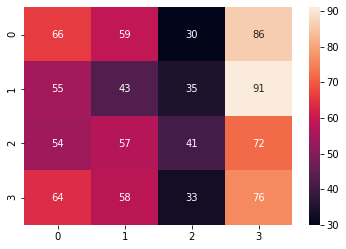

In [105]:
conf_matrix, heatmap = confMatrixHeatmap(y_pred = predictions,y_true = test.labels )



---


## Test zone 



---

